In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm # p-values
from sklearn.model_selection import train_test_split
import xgboost as xgb
import catboost as cat
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import itertools
from tqdm import tqdm, tnrange
pd.options.display.max_columns = 1000

from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
test = pd.read_csv('test_FD001.txt', parse_dates=False, delimiter=" ", decimal=".", header=None)
RUL = pd.read_csv('RUL_FD001.txt', parse_dates=False, decimal=".", header=None)
tableNA = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
tableNA.columns = ['train', 'test']
#We will first drop the columns that consisted of missing values:
train.drop(train.columns[[-1,-2]], axis=1, inplace=True)
test.drop(test.columns[[-1,-2]], axis=1, inplace=True)

cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
train.columns = cols
test.columns = cols

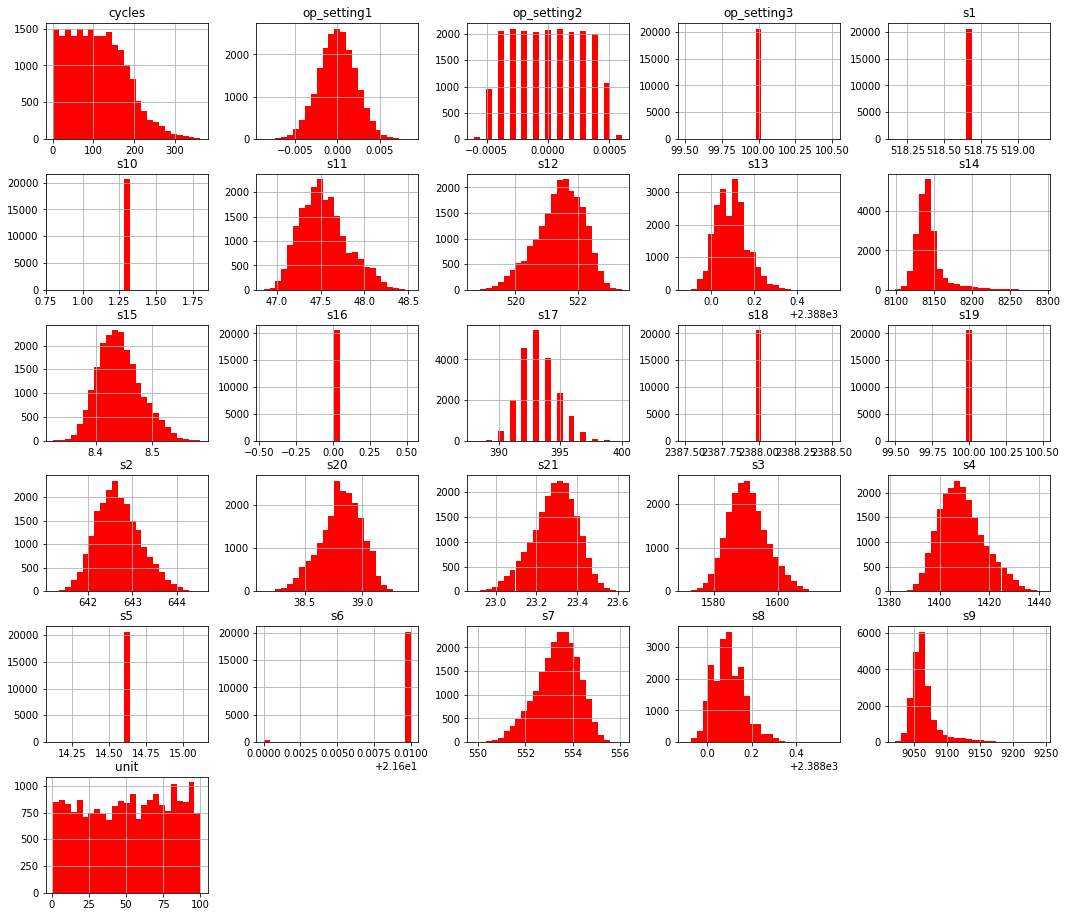

In [3]:
train.hist(bins=25, figsize=(18,16),color='red')
plt.show()

In [4]:
train.drop(['s1', 's5','s6', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5','s6', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

In [5]:
train = train[train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [6]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

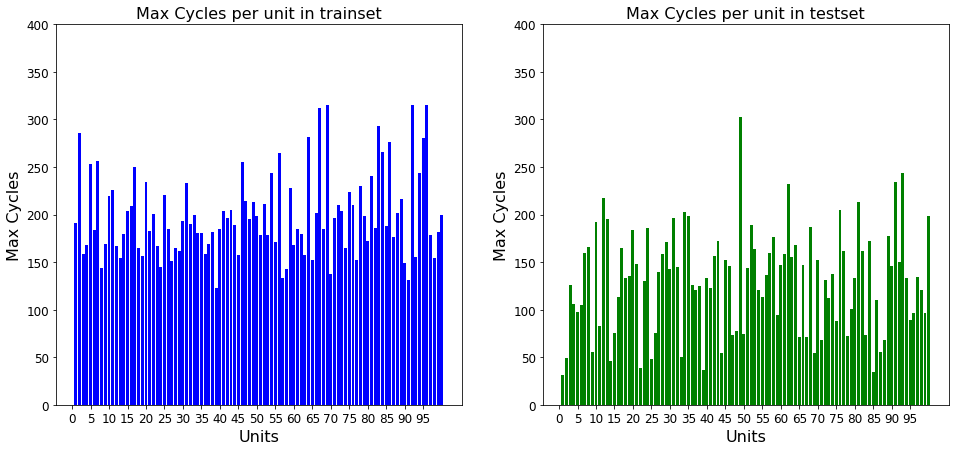

In [7]:
fig = plt.figure(figsize = (16,7))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='Blue')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per unit in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='green')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max Cycles', fontsize=16)
plt.title('Max Cycles per unit in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
train['TTF'] = train['maxcycles'] - train['cycles']

In [9]:
scaler = MinMaxScaler()
ntrain = train.copy()
ntrain.iloc[:,2:18] = scaler.fit_transform(ntrain.iloc[:,2:18])
ntest = test.copy()
pd.DataFrame(ntest.columns).transpose()
ntest.iloc[:,2:18] = scaler.transform(ntest.iloc[:,2:18])
ntest.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,13096.0,51.543907,28.289423,1.000000,28.000000,52.000000,76.000000,100.000000
cycles,13096.0,76.836515,53.057749,1.000000,33.000000,69.000000,113.000000,303.000000
op_setting1,13096.0,0.499140,0.169437,-0.130769,0.384615,0.500000,0.615385,1.100000
op_setting2,13096.0,0.503532,0.245025,0.000000,0.333333,0.500000,0.750000,1.083333
s2,13096.0,0.425955,0.134983,-0.026936,0.332492,0.420875,0.515152,1.040404
s3,13096.0,0.431168,0.136888,-0.090287,0.335431,0.428181,0.520451,0.963338
s4,13096.0,0.419112,0.124666,0.039888,0.329916,0.413607,0.499534,0.952656
s7,13096.0,0.590160,0.132804,0.029240,0.502924,0.598441,0.684211,0.996101
s8,13096.0,0.427411,0.143604,-0.025000,0.325000,0.425000,0.525000,1.000000
s9,13096.0,0.321374,0.106354,0.006324,0.252674,0.311262,0.374407,1.219939


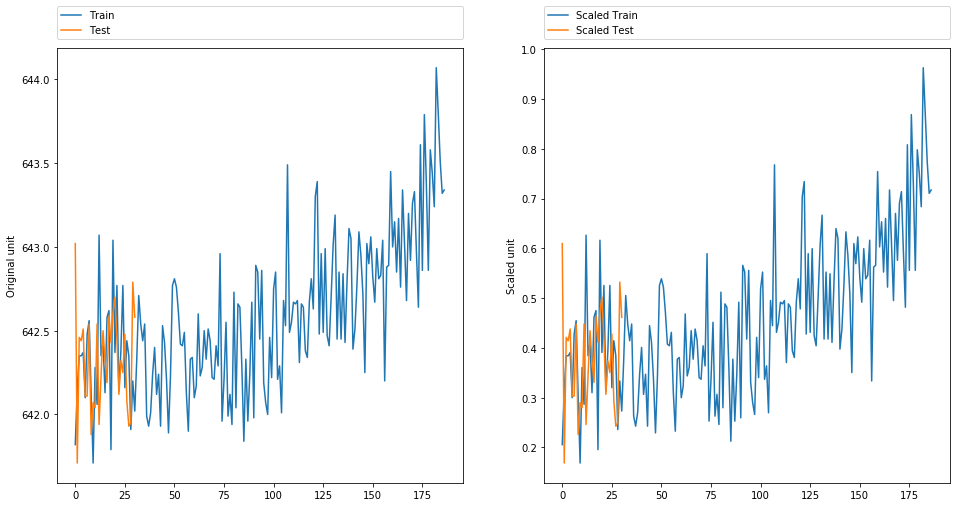

In [10]:
fig = plt.figure(figsize = (16, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2)
plt.plot(test[test.unit==1].s2)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2)
plt.plot(ntest[ntest.unit==1].s2)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [11]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())
fTTFz = []
fTTF = []

for i in range(train['unit'].min(),train['unit'].max()+1):
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF

In [12]:
ntrain.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF
0,1,1,0.446154,0.166667,0.205387,0.474966,0.342032,0.707602,0.400,0.207756,0.416107,0.586538,0.309524,0.358724,0.398392,0.375,0.735849,0.700942,191,190,1.000000
1,1,2,0.646154,0.250000,0.316498,0.532969,0.389376,0.588694,0.350,0.188041,0.429530,0.735577,0.428571,0.285332,0.453327,0.375,0.679245,0.708044,191,189,0.994737
2,1,3,0.169231,0.750000,0.383838,0.428181,0.409133,0.688109,0.450,0.270529,0.281879,0.769231,0.333333,0.303242,0.390799,0.125,0.632075,0.585456,191,188,0.989474
3,1,4,0.553846,0.500000,0.383838,0.285910,0.365704,0.725146,0.525,0.238352,0.187919,0.875000,0.452381,0.309418,0.169272,0.375,0.566038,0.631311,191,187,0.984211
4,1,5,0.353846,0.333333,0.390572,0.287551,0.446785,0.637427,0.400,0.291082,0.288591,0.713942,0.357143,0.309110,0.442608,0.500,0.584906,0.678400,191,186,0.978947


In [13]:
X_train = ntrain.iloc[:,1:18]
Y_train = ntrain.iloc[:, 20]
X_test = ntest.iloc[:,1:18]

In [14]:
Y_train.head()

0    1.000000
1    0.994737
2    0.989474
3    0.984211
4    0.978947
Name: fTTF, dtype: float64

In [15]:
X_train.head()

,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,0.446154,0.166667,0.205387,0.474966,0.342032,0.707602,0.400,0.207756,0.416107,0.586538,0.309524,0.358724,0.398392,0.375,0.735849,0.700942
1,2,0.646154,0.250000,0.316498,0.532969,0.389376,0.588694,0.350,0.188041,0.429530,0.735577,0.428571,0.285332,0.453327,0.375,0.679245,0.708044
2,3,0.169231,0.750000,0.383838,0.428181,0.409133,0.688109,0.450,0.270529,0.281879,0.769231,0.333333,0.303242,0.390799,0.125,0.632075,0.585456
3,4,0.553846,0.500000,0.383838,0.285910,0.365704,0.725146,0.525,0.238352,0.187919,0.875000,0.452381,0.309418,0.169272,0.375,0.566038,0.631311
4,5,0.353846,0.333333,0.390572,0.287551,0.446785,0.637427,0.400,0.291082,0.288591,0.713942,0.357143,0.309110,0.442608,0.500,0.584906,0.678400


X_train['mean_samp'] = X_train.mean(axis=1)
X_train['var_samp'] = np.log1p(X_train.var(axis=1))
X_train['sum_samp'] = X_train.sum(axis=1)

X_test['mean_samp'] = X_test.mean(axis=1)
X_test['var_samp'] = np.log1p(X_test.var(axis=1))
X_test['sum_samp'] = X_test.sum(axis=1)

# Feature Selection
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax<0.805):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols

selected_features_BE

In [16]:
X_train1 = X_train
X_train1.head()

,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,0.446154,0.166667,0.205387,0.474966,0.342032,0.707602,0.400,0.207756,0.416107,0.586538,0.309524,0.358724,0.398392,0.375,0.735849,0.700942
1,2,0.646154,0.250000,0.316498,0.532969,0.389376,0.588694,0.350,0.188041,0.429530,0.735577,0.428571,0.285332,0.453327,0.375,0.679245,0.708044
2,3,0.169231,0.750000,0.383838,0.428181,0.409133,0.688109,0.450,0.270529,0.281879,0.769231,0.333333,0.303242,0.390799,0.125,0.632075,0.585456
3,4,0.553846,0.500000,0.383838,0.285910,0.365704,0.725146,0.525,0.238352,0.187919,0.875000,0.452381,0.309418,0.169272,0.375,0.566038,0.631311
4,5,0.353846,0.333333,0.390572,0.287551,0.446785,0.637427,0.400,0.291082,0.288591,0.713942,0.357143,0.309110,0.442608,0.500,0.584906,0.678400


In [17]:
X_test1 = X_test
X_test1.head()

,cycles,op_setting1,op_setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,0.676923,0.750000,0.609428,0.354309,0.297484,0.617934,0.350,0.244769,0.234899,0.600962,0.333333,0.224189,0.334524,0.375,0.547170,0.630693
1,2,0.292308,0.250000,0.168350,0.440766,0.245480,0.803119,0.275,0.284293,0.436242,0.706731,0.404762,0.369017,0.223314,0.500,0.698113,0.658638
2,3,0.523077,0.583333,0.420875,0.399453,0.355825,0.658869,0.375,0.307914,0.436242,0.661058,0.333333,0.271024,0.508263,0.500,0.754717,0.697236
3,4,0.823077,0.500000,0.414141,0.322298,0.450513,0.651072,0.325,0.199386,0.288591,0.519231,0.380952,0.299846,0.274230,0.250,0.679245,0.631002
4,5,0.607692,0.500000,0.437710,0.406293,0.366636,0.668616,0.275,0.192504,0.308725,0.704327,0.333333,0.265260,0.325145,0.125,0.669811,0.691678


In [18]:
kfold = 5
fold = list(KFold(n_splits = kfold, shuffle = True, random_state = 2019).split(X_train1))

In [19]:
sub1 = pd.DataFrame()
sub1["target"] = np.zeros_like(X_test1.cycles.values)
subb1 = pd.DataFrame()
subb1["train"] = np.zeros_like(X_train1.cycles.values)
score = 0
for i, (train_index, test_index) in enumerate(fold):
    print("Fold - %.f" %(i+1))
    X_tr = X_train1.loc[train_index, :]
    y_tr = Y_train[train_index]
    X_valid = X_train1.loc[test_index, :]
    y_valid = Y_train[test_index]
    
    model = cat.CatBoostRegressor(iterations=600,
                                 learning_rate=0.005,
                                 depth=3,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.99,
                                 random_seed = 2019,
                                 bagging_temperature = 0.001,
                                 metric_period = None,
                                 early_stopping_rounds=50 
                                )
    model.fit(X_tr, y_tr, eval_set=(X_valid, y_valid), verbose = False)
    
    test_pred = model.predict(X_test1)
    valid_pred = model.predict(X_valid)
    train_pred = model.predict(X_train1)
    
    score += np.sqrt(mean_squared_error(y_valid, valid_pred))/kfold
    
    sub1["target"] += test_pred/kfold
    subb1["train"] += train_pred/kfold
    
    del X_tr, X_valid, y_tr, y_valid
    gc.collect()
print("Training RMSE: ", np.sqrt(mean_squared_error(Y_train, subb1["train"].values)))
print("Validation RMSE: ", score)

Fold - 1
Fold - 2
Fold - 3
Fold - 4
Fold - 5
Training RMSE:  0.07335288566861893
Validation RMSE:  0.0735991964701781


In [20]:
score = model.predict(X_test1)
print(score.min(), score.max())

0.07534327553983894 0.9102347261477522


In [21]:
test1 = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test1.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test1['score'] = score
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test1['maxpredcycles'] = totcycles(test1)
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])

test1['RUL'] = RULfunction(test1)

In [22]:
t = test1.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []

for i in range(test1.unit.min(), test1.unit.max()+1):
    npredictedRUL=test1[test1.unit==i].iloc[test1[test1.unit==i].cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)

xtrueRUL = list(RUL.loc[:,0])
otrueRUL = []

for i in range(0,len(xtrueRUL)):
    otrueRUL = np.concatenate((otrueRUL, list(reversed(np.arange(xtrueRUL[i])))))
    
xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []

for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL, list(reversed(np.arange(float(xpredictedRUL[i]))))))

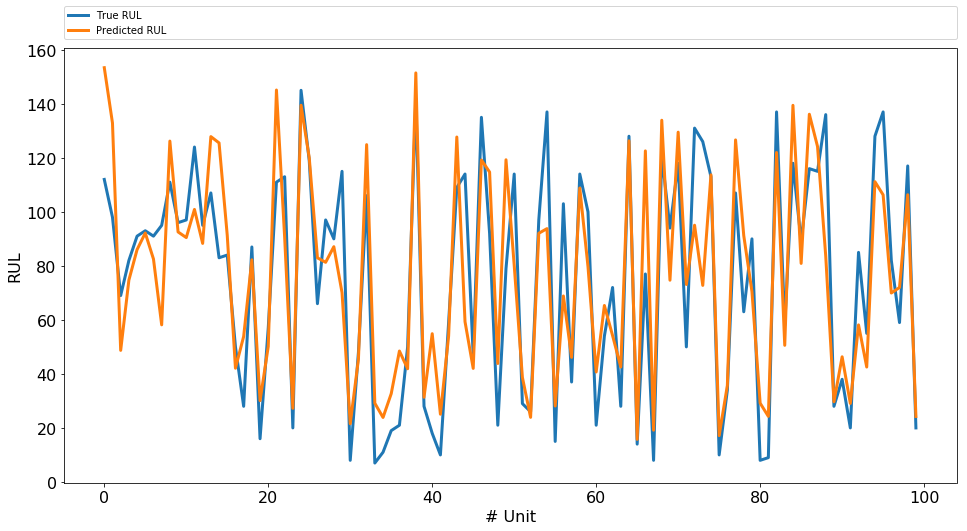

In [23]:
plt.figure(figsize = (16, 8))
plt.plot(RUL,linewidth=3)
plt.plot(predictedRUL,linewidth=3)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.show()

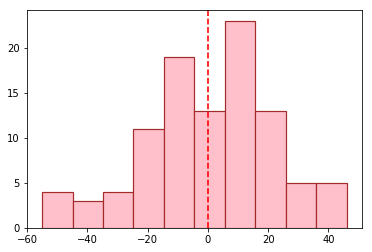

In [24]:
df1 = pd.concat([pd.Series(RUL[0]), pd.Series(xpredictedRUL)], axis=1)
df1.columns = ['true', 'predicted']
df1['diff'] = df1['predicted']-df1['true']

plt.hist(df1['diff'].astype(int), bins=10, color="pink", edgecolor='brown', linewidth=1.2)
plt.axvline(0, color="red", linestyle='dashed', linewidth=1.6)
plt.show()

In [25]:
pd.DataFrame({'Count': [(df1['diff'].astype(int)<0).sum(), (df1['diff'].astype(int)==0).sum(), 
                        (df1['diff'].astype(int)>0).sum()]}, columns=['Count'], index=['Smaller', 'Zero', 'Larger'])

,Count
Smaller,47
Zero,0
Larger,53


In [26]:
mse = mean_squared_error(RUL, xpredictedRUL)
print (mse)
print ('Root Mean Squared Error (RMSE): '+ str(np.sqrt(mse)))

461.49
Root Mean Squared Error (RMSE): 21.482318310647944
